In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import polars as pl
import scipy
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
if "CI" not in os.environ:
    df = pl.read_parquet(
        "https://osf.io/gk2ty/download",
        use_pyarrow=True,
    )
    print(df.columns)


In [3]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("SLIP_INSERTION_BOOL_MASK").any().over(
            ["Treatment", "Run ID", "Generation Born"],
        ).alias("SLIP_INSERTION_BOOL_MASK any"),
    )


In [4]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("Is Task Coding Site").any().over(
            ["Treatment", "Run ID", "Generation Born", "Site"],
        )
        .alias("is any coding site"),
    )


In [5]:
if "CI" not in os.environ:
    df = df.with_columns(
            pl.col("Is Task Coding Site Delta").sum().over(
                ["Treatment", "Run ID", "Generation Born"],
            )
            .alias("is task coding site delta sum"),
        )


In [6]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("has task").sum().over(
            ["Treatment", "Run ID", "Generation Born", "Site"],
        )
        .alias("num tasks has"),
    )


In [7]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("is any coding site").sum().over(
            ["Treatment", "Run ID", "Generation Born", "Task",],
        ).alias("num coding sites"),
    )


In [8]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("Is Task Coding Site Cumulative Count").sum().over(
            ["Site", "Lineage Generation Index", "Treatment", "Run ID"]
        ).sign().alias("coded for tasks")
    )


In [9]:
if "CI" not in os.environ:
    df = df.with_columns(
        pl.col("coded for tasks").sum().over(
            ["Treatment", "Run ID", "Generation Born", "Task",],
        ).alias("num coded sites"),
    )


In [10]:
if "CI" not in os.environ:
    df = df.with_columns(
        Components=pl.col("Task").replace_strict(
            {
                "AND": 2,
                "ANDNOT": 3,
                "NAND": 1,
                "NOR": 4,
                "NOT": 1,
                "OR": 3,
                "ORNOT": 2,
                "XOR": 4,
                "EQUALS": 5,
            },
        ),
    )


In [11]:
if "CI" not in os.environ:
    df = df.with_columns(
        MaxComponents=(
            pl.col("Components")
            * pl.col("has task")
        ).max().over(
            ["Treatment", "Run ID", "Generation Born"],
        ).alias("max components"),
    )


In [12]:
if "CI" not in os.environ:
    df = df.with_columns(
        (
            pl.col("MaxComponents") == 5
        ).alias("has equal"),
    )


In [13]:
if "CI" not in os.environ:
    dfx = df.group_by(
        ["Treatment", "Run ID", "Generation Born"],
    ).first()
    dfx.write_parquet("/tmp/num-coding-sites.pqt")
else:
    dfx = pl.read_parquet("https://osf.io/etsfy/download", use_pyarrow=True)


In [14]:
dfx = dfx.with_columns(
    Treatment=pl.col("Treatment").map_elements(
        {
            "Baseline-Treatment": "Baseline",
            "Long-Ancestor-Control-Treatment": "Long-genome",
            "Slip-duplicate": "Slip-duplicate",
        }.__getitem__,
        return_dtype=str,
    ),
)


In [15]:
dfx = dfx.with_columns(
    (
        pl.col("num coding sites") / pl.col("Genome Length")
    ).alias("frac coding sites")
)


In [16]:
dfx = dfx.with_columns(
    (dfx["num coded sites"] - dfx["num coding sites"]).alias("num free sites"),
)


In [17]:
def ensure_combinations(df, group_columns, generation_column):
    df = df.with_columns(
        pl.col(generation_column).cast(pl.Int64),
    )
    # Step 1: Create full range of generations
    min_gen = 0
    max_gen = 600
    full_generations = pl.DataFrame({generation_column: np.arange(min_gen, max_gen + 1)})

    # Step 2: Get unique values of group columns
    unique_groups = df.select(group_columns).unique()

    # Step 3: Generate all combinations
    all_combinations = unique_groups.join(full_generations, how="cross")

    # Step 4: Join the original DataFrame with the complete combinations
    complete_df = all_combinations.join(df, on=group_columns + [generation_column], how="left")

    return complete_df


In [18]:
big_df = ensure_combinations(dfx, ["Treatment", "Run ID"], "Generation Born")
big_df = big_df.fill_null(strategy="forward")
big_df


Treatment,Run ID,Generation Born,Task,Genome Length,Lineage Generation Index,Is Task Coding Site,Is Viability Site,Is Task Coding Site Cumulative Count,Is Viability Site Cumulative Count,Prev Is Task Coding Site Cumulative Count,Prev Is Viability Site Cumulative Count,Prev Is Task Coding Site,Prev Is Viability Site,Site,Has Task,has task,delta has task,Delta Has Task,CHILD_SOURCE_MAP,POINT_MUTATION_BOOL_MASK,SLIP_INSERTION_ORIGIN_BOOL_MASK,SLIP_INSERTION_RESULT_BOOL_MASK,GENOME_CHARACTERS,Is Task Coding Site Delta,Is Viability Site Delta,Point Mutation Cumulative Count,Slip Insertion Cumulative Count,Prev Slip Insertion Cumulative Count,SLIP_INSERTION_BOOL_MASK,Update Born,SLIP_INSERTION_BOOL_MASK any,is any coding site,is task coding site delta sum,num tasks has,num coding sites,coded for tasks,num coded sites,Components,MaxComponents,has equal,frac coding sites,num free sites
str,cat,i64,cat,i64,u16,bool,bool,i16,i16,i16,i16,bool,bool,u16,bool,bool,i8,i8,i16,bool,bool,bool,cat,i8,i8,u16,u16,u16,bool,i32,bool,bool,i64,u32,u32,i64,i64,i64,i64,bool,f64,i64
"""Baseline""","""run_1538""",0,"""AND""",100,0,false,true,0,1,0,1,false,false,0,false,false,0,0,-1,false,false,false,"""w""",0,0,0,0,0,false,-1,false,false,0,0,0,0,0,2,0,false,0.0,0
"""Baseline""","""run_1538""",1,"""AND""",100,0,false,true,0,1,0,1,false,false,0,false,false,0,0,-1,false,false,false,"""w""",0,0,0,0,0,false,-1,false,false,0,0,0,0,0,2,0,false,0.0,0
"""Baseline""","""run_1538""",2,"""AND""",100,0,false,true,0,1,0,1,false,false,0,false,false,0,0,-1,false,false,false,"""w""",0,0,0,0,0,false,-1,false,false,0,0,0,0,0,2,0,false,0.0,0
"""Baseline""","""run_1538""",3,"""AND""",100,0,false,true,0,1,0,1,false,false,0,false,false,0,0,-1,false,false,false,"""w""",0,0,0,0,0,false,-1,false,false,0,0,0,0,0,2,0,false,0.0,0
"""Baseline""","""run_1538""",4,"""AND""",100,0,false,true,0,1,0,1,false,false,0,false,false,0,0,-1,false,false,false,"""w""",0,0,0,0,0,false,-1,false,false,0,0,0,0,0,2,0,false,0.0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Long-genome""","""run_1753""",596,"""AND""",1000,204,false,true,0,205,0,204,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,49284,false,false,-3,7,89,0,106,2,4,false,0.089,17
"""Long-genome""","""run_1753""",597,"""AND""",1000,204,false,true,0,205,0,204,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,49284,false,false,-3,7,89,0,106,2,4,false,0.089,17
"""Long-genome""","""run_1753""",598,"""AND""",1000,204,false,true,0,205,0,204,false,true,0,true,true,0,0,0,false,false,false,"""w""",0,0,0,0,0,false,49284,false,false,-3,7,89,0,106,2,4,false,0.089,17


In [19]:
dfx = big_df


teeplots/hue=treatment+post=plt-xlim-0-600+viz=lineplot+x=generation-born+y=num-coding-sites+ext=.pdf


teeplots/hue=treatment+post=plt-xlim-0-600+viz=lineplot+x=generation-born+y=num-coding-sites+ext=.png


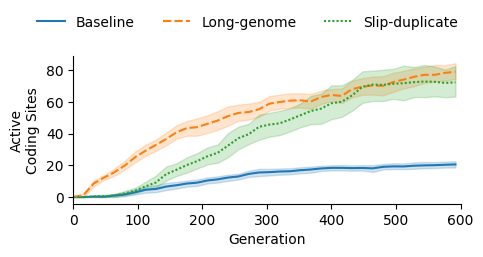

In [20]:
with mpl.rc_context({"figure.figsize": (5, 4)}):
    with tp.teed(
        sns.lineplot,
        hue="Treatment",
        style="Treatment",
        y="num coding sites",
        x="Generation Born",
        data=dfx.filter(
            pl.col("Generation Born") % 16 == 0
        ).to_pandas(),
        teeplot_outexclude="style",
        teeplot_postprocess="plt.xlim(0, 600)",
    ) as ax:
        sns.move_legend(
            ax, "lower center",
            bbox_to_anchor=(.45, 1.1), ncol=3, title=None, frameon=False,
        )
        ax.spines[["right", "top"]].set_visible(False)
        ax.set_xlabel("Generation")
        ax.set_ylabel("Active\nCoding Sites")
        ax.set_aspect(0.38 / ax.get_data_ratio(), adjustable="box")


In [21]:
fil = dfx.filter(pl.col("Generation Born") == 600)
for what in ["num coding sites"]:
    result = scipy.stats.mannwhitneyu(
        fil.filter(pl.col("Treatment") == "Slip-duplicate")[what].to_numpy(),
        fil.filter(pl.col("Treatment") == "Baseline")[what].to_numpy(),
    )
    print(what, result)

for what in ["num coding sites"]:
    result = scipy.stats.mannwhitneyu(
        fil.filter(pl.col("Treatment") == "Slip-duplicate")[what].to_numpy(),
        fil.filter(pl.col("Treatment") == "Long-genome")[what].to_numpy(),
    )
    print(what, result)

for what in ["num coding sites"]:
    result = scipy.stats.mannwhitneyu(
        fil.filter(pl.col("Treatment") == "Baseline")[what].to_numpy(),
        fil.filter(pl.col("Treatment") == "Long-genome")[what].to_numpy(),
    )
    print(what, result)


num coding sites MannwhitneyuResult(statistic=np.float64(854.5), pvalue=np.float64(2.275468732265418e-09))
num coding sites MannwhitneyuResult(statistic=np.float64(361.0), pvalue=np.float64(0.190539256157239))


num coding sites MannwhitneyuResult(statistic=np.float64(0.0), pvalue=np.float64(2.92838620529399e-11))


teeplots/col=treatment+hue=has-equal+kind=scatter+viz=relplot+x=num-coded-sites+y=num-coding-sites+ext=.pdf


teeplots/col=treatment+hue=has-equal+kind=scatter+viz=relplot+x=num-coded-sites+y=num-coding-sites+ext=.png


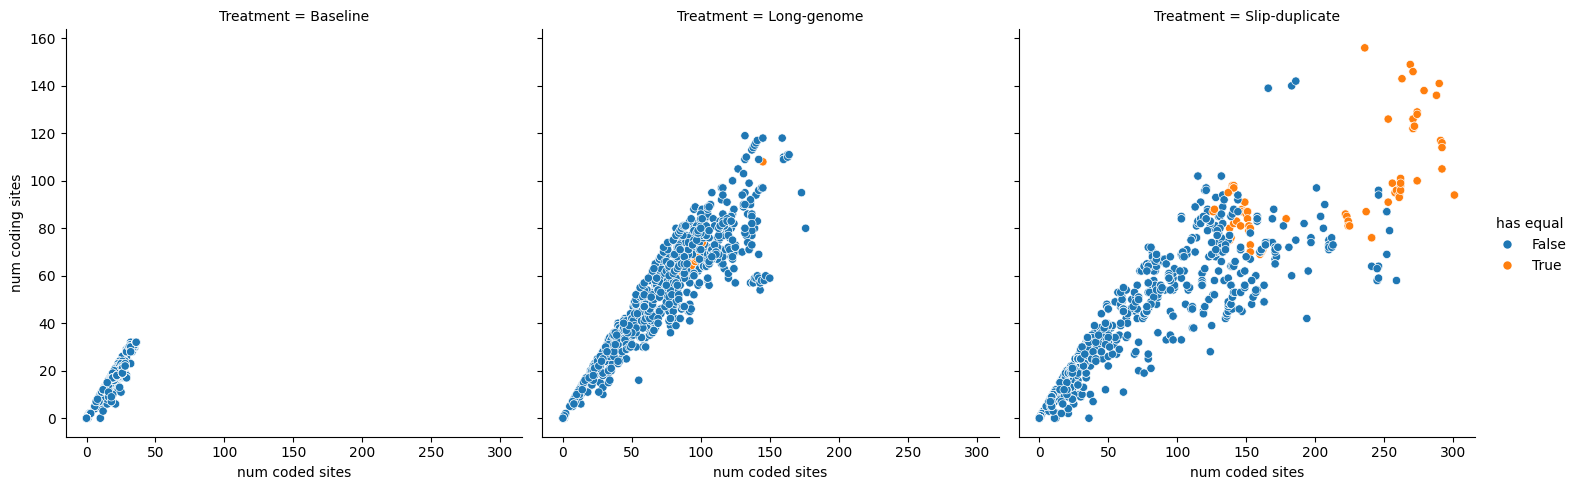

In [22]:
with tp.teed(
    sns.relplot,
    col="Treatment",
    hue="has equal",
    y="num coding sites",
    x="num coded sites",
    data=dfx.filter(
        pl.col("Generation Born") % 16 == 0
    ).to_pandas(),
    kind="scatter",
) as g:
    pass


teeplots/hue=treatment+post=plt-xlim-0-600+viz=lineplot+x=generation-born+y=num-coded-sites+ext=.pdf
teeplots/hue=treatment+post=plt-xlim-0-600+viz=lineplot+x=generation-born+y=num-coded-sites+ext=.png


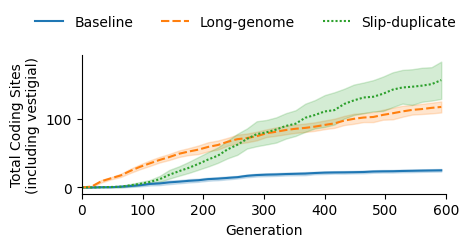

In [23]:
with mpl.rc_context({"figure.figsize": (4.7, 4)}):
    with tp.teed(
        sns.lineplot,
        hue="Treatment",
        style="Treatment",
        y="num coded sites",
        x="Generation Born",
        data=dfx.filter(
            pl.col("Generation Born") % 16 == 0
        ).to_pandas(),
        teeplot_outexclude="style",
        teeplot_postprocess="plt.xlim(0, 600)",
        # teeplot_postprocess="plt.xscale('log')",
    ) as ax:
        sns.move_legend(
            ax, "lower center",
            bbox_to_anchor=(.45, 1.1), ncol=3, title=None, frameon=False,
        )
        ax.spines[["right", "top"]].set_visible(False)
        ax.set_xlabel("Generation")
        ax.set_ylabel("Total Coding Sites\n(including vestigial)")
        ax.set_aspect(0.38 / ax.get_data_ratio(), adjustable="box")


In [24]:
fil = dfx.filter(pl.col("Generation Born") == 600)
for what in ["num coded sites"]:
    result = scipy.stats.mannwhitneyu(
        fil.filter(pl.col("Treatment") == "Slip-duplicate")[what].to_numpy(),
        fil.filter(pl.col("Treatment") == "Baseline")[what].to_numpy(),
    )
    print(what, result)

for what in ["num coded sites"]:
    result = scipy.stats.mannwhitneyu(
        fil.filter(pl.col("Treatment") == "Slip-duplicate")[what].to_numpy(),
        fil.filter(pl.col("Treatment") == "Long-genome")[what].to_numpy(),
    )
    print(what, result)

for what in ["num coded sites"]:
    result = scipy.stats.mannwhitneyu(
        fil.filter(pl.col("Treatment") == "Baseline")[what].to_numpy(),
        fil.filter(pl.col("Treatment") == "Long-genome")[what].to_numpy(),
    )
    print(what, result)


num coded sites MannwhitneyuResult(statistic=np.float64(891.0), pvalue=np.float64(7.282928775963637e-11))
num coded sites MannwhitneyuResult(statistic=np.float64(630.0), pvalue=np.float64(0.00794769551964776))
num coded sites MannwhitneyuResult(statistic=np.float64(0.0), pvalue=np.float64(2.9728686875000726e-11))


teeplots/hue=treatment+post=plt-xlim-0-600+viz=lineplot+x=generation-born+y=num-free-sites+ext=.pdf
teeplots/hue=treatment+post=plt-xlim-0-600+viz=lineplot+x=generation-born+y=num-free-sites+ext=.png


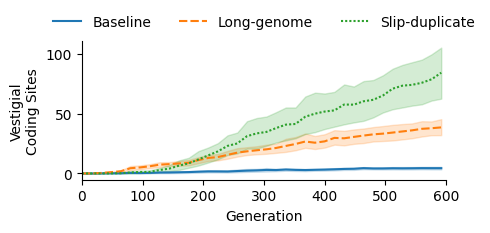

In [25]:
with mpl.rc_context({"figure.figsize": (4.7, 4)}):
    with tp.teed(
        sns.lineplot,
        hue="Treatment",
        style="Treatment",
        y="num free sites",
        x="Generation Born",
        data=dfx.filter(
            pl.col("Generation Born") % 16 == 0
        ).with_columns(
            (pl.col("num coded sites") - pl.col("num coding sites")).alias("num free sites"),
        ).to_pandas(),
        # teeplot_postprocess="plt.xscale('log')",
        teeplot_outexclude="style",
        teeplot_postprocess="plt.xlim(0, 600)",
    ) as ax:
        sns.move_legend(
            ax, "lower center",
            bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
        )
        ax.spines[["right", "top"]].set_visible(False)
        ax.set_xlabel("Generation")
        ax.set_ylabel("Vestigial\nCoding Sites")
        ax.set_aspect(0.38 / ax.get_data_ratio(), adjustable="box")


teeplots/hue=treatment+post=plt-xlim-0-600+viz=lineplot+x=generation-born+y=num-tasks-has+ext=.pdf
teeplots/hue=treatment+post=plt-xlim-0-600+viz=lineplot+x=generation-born+y=num-tasks-has+ext=.png


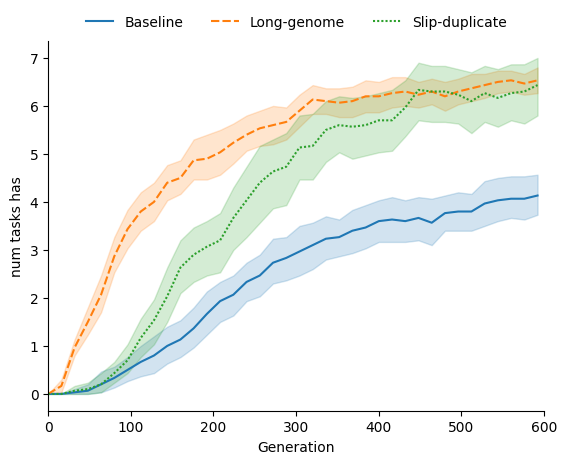

In [26]:
with tp.teed(
    sns.lineplot,
    hue="Treatment",
    style="Treatment",
    y="num tasks has",
    x="Generation Born",
    data=dfx.filter(
        pl.col("Generation Born") % 16 == 0
    ).to_pandas(),
    # teeplot_postprocess="plt.xscale('log')",
    teeplot_outexclude="style",
    teeplot_postprocess="plt.xlim(0, 600)",
) as ax:
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    )
    ax.spines[["right", "top"]].set_visible(False)
    ax.set_xlabel("Generation")


teeplots/hue=treatment+post=plt-xlim-0-600+viz=lineplot+x=generation-born+y=maxcomponents+ext=.pdf
teeplots/hue=treatment+post=plt-xlim-0-600+viz=lineplot+x=generation-born+y=maxcomponents+ext=.png


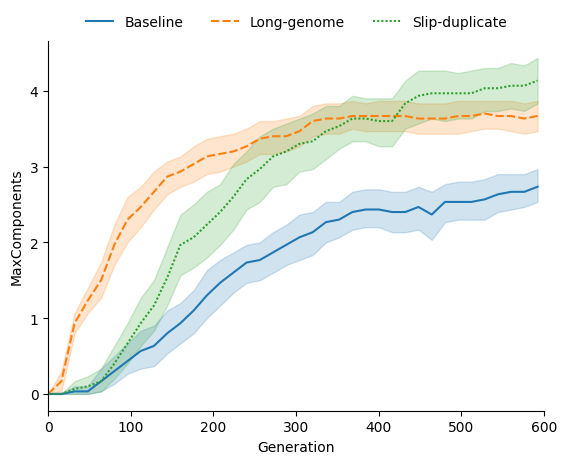

In [27]:
with tp.teed(
    sns.lineplot,
    hue="Treatment",
    style="Treatment",
    y="MaxComponents",
    x="Generation Born",
    data=dfx.filter(
        pl.col("Generation Born") % 16 == 0
    ).to_pandas(),
    # teeplot_postprocess="plt.xscale('log')",
    teeplot_outexclude="style",
    teeplot_postprocess="plt.xlim(0, 600)",
) as ax:
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    )
    ax.spines[["right", "top"]].set_visible(False)
    ax.set_xlabel("Generation")


teeplots/hue=treatment+post=plt-xlim-0-600+viz=lineplot+x=generation-born+y=frac-coding-sites+ext=.pdf
teeplots/hue=treatment+post=plt-xlim-0-600+viz=lineplot+x=generation-born+y=frac-coding-sites+ext=.png


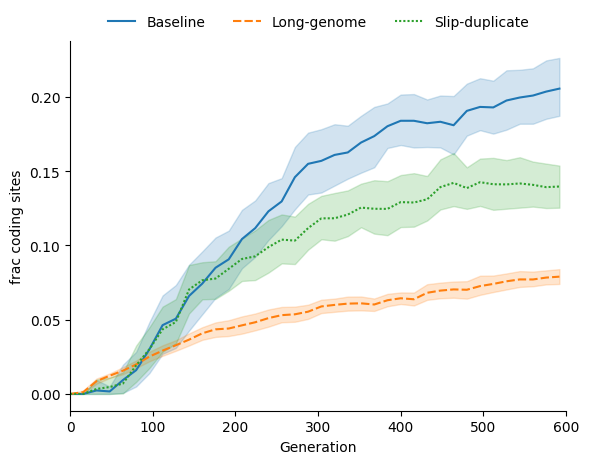

In [28]:
with tp.teed(
    sns.lineplot,
    hue="Treatment",
    style="Treatment",
    y="frac coding sites",
    x="Generation Born",
    data=dfx.filter(
        pl.col("Generation Born") % 16 == 0
    ).to_pandas(),
    # teeplot_postprocess="plt.xscale('log')",
    teeplot_outexclude="style",
    teeplot_postprocess="plt.xlim(0, 600)",
) as ax:
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    )
    ax.spines[["right", "top"]].set_visible(False)
    ax.set_xlabel("Generation")


In [29]:
fil = dfx.filter(pl.col("Generation Born") == 599)
for what in ["num coding sites", "num coded sites"]:
    result = scipy.stats.mannwhitneyu(
        fil.filter(pl.col("Treatment") == "Slip-duplicate")[what].to_numpy(),
        fil.filter(pl.col("Treatment") == "Long-Ancestor-Control-Treatment")[what].to_numpy(),
    )
    print(what, result)


num coding sites MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))
num coded sites MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))


/tmp/ipykernel_4259/1458301281.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  result = scipy.stats.mannwhitneyu(


In [30]:
fil = dfx.filter(pl.col("Generation Born") == 599)
for what in ["num coding sites", "num coded sites"]:
    result = scipy.stats.mannwhitneyu(
        fil.filter(pl.col("Treatment") == "Slip-duplicate")[what].to_numpy(),
        fil.filter(pl.col("Treatment") == "Baseline-Treatment")[what].to_numpy(),
    )
    print(what, result)


num coding sites MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))
num coded sites MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))


/tmp/ipykernel_4259/1030065119.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  result = scipy.stats.mannwhitneyu(


In [31]:
fil = dfx.filter(pl.col("Generation Born") == 599)
for what in ["num coding sites", "num coded sites"]:
    for treatment in ["Slip-duplicate", "Long-Ancestor-Control-Treatment", "Baseline-Treatment"]:
        arr = fil.filter(pl.col("Treatment") == treatment)[what].to_numpy()
        print(what, treatment, np.mean(arr), np.std(arr))


num coding sites Slip-duplicate 71.66666666666667 26.658748824520796
num coding sites Long-Ancestor-Control-Treatment nan nan
num coding sites Baseline-Treatment nan nan
num coded sites Slip-duplicate 157.2 72.27281646649728
num coded sites Long-Ancestor-Control-Treatment nan nan
num coded sites Baseline-Treatment nan nan


/home/runner/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/runner/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/runner/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/runner/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/runner/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
